In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import heapq
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
import pandas as pd
from IPython.display import HTML

In [ ]:
class Bus:
    def __init__(self, bus_id, bus_type, init_stop, controller):
        self.bus_id = bus_id
        self.bus_type = bus_type
        
        self.inbox = [] # (tick, sender, message)
        self.bus_passengers = [] # (passenger_id, bus_stop)
        self.previous_stop = None
        self.current_stop = init_stop # central station has to be setted as init_stop
        self.next_stop = None
        
        self.x = init_stop.x
        self.y = init_stop.y
        
        self.progress = 0
        
        self.controller = controller
        
        self.connections = controller.connections
        
        self.init_bus()
        
   
    
    def update(self):
        if self.previous_stop and self.next_stop:
            distance = self.controller.adj_matrix[self.previous_stop.stop_id, self.next_stop.stop_id]
            self.x = self.previous_stop.x + (self.next_stop.x - self.previous_stop.x) * self.progress
            self.y = self.previous_stop.y + (self.next_stop.y - self.previous_stop.y) * self.progress
        else:
            self.x = self.current_stop.x
            self.y = self.current_stop.y
            
        self.execute_action()
        
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.bus_id == other.bus_id
        else:
            return False
    
    def add_bus(self, vehicle_type):
        self.controller.add_bus(vehicle_type)
        
    def travel_to(self, bus_stop):
        self.controller.travel_to(self, bus_stop)
        
    def pick_up_passenger(self, passenger_id):
        self.controller.pick_up_passenger(self, passenger_id)
        
    def init_bus(self):
        pass
    
    def execute_action(self):
        pass
    

In [ ]:
class TestBus(Bus):
    def init_bus(self):
        pass
    
    def execute_action(self):
        if self.current_stop:
            self.travel_to(np.random.choice(self.connections[self.current_stop.stop_id]))
        if self.controller.ticks %5 == 0 and self.bus_id == 24 :
            self.add_bus(1)
        
        

In [ ]:
class BusStop:
    def __init__(self, stop_id, name, x, y):
        self.stop_id = stop_id
        self.name = name
        self.passengers_waiting = []
        self.x = x
        self.y = y
        # self.passengers_that_arrived = [] 
        
    def add_waiting_passenger(self, passenger):
        self.passengers_waiting.append(passenger)
        
    def remove_waiting_passenger(self, passenger):
        assert passenger in self.passengers_waiting 
        self.passengers_waiting.remove(passenger)
        
    def distance(self, other):
        return np.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.stop_id == other.stop_id
        else:
            return False

In [ ]:
class Passenger:
    def __init__(self, passenger_id, source, destination, spawn_time):
        self.passenger_id = passenger_id
        self.destination = destination
        self.source = source
        self.spawn_time = spawn_time
        
    def get_waiting_time(current_time):
        return current_time-self.spawn_time
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.passenger_id == other.passenger_id
        else:
            return False
        

In [ ]:
class ActionHeap(object):
    def __init__(self, initial=None, key=lambda x:x[0]):
        self.key = key
        if initial:
            self._data = [(key(item), item) for item in initial]
            heapq.heapify(self._data)
        else:
            self._data = []

    def push(self, time, action):
        heapq.heappush(self._data, (time, action))

    def pop(self):
        return heapq.heappop(self._data)[1]
    
    def peek(self):
        if len(self._data) > 0:
            return heapq.nsmallest(1, self._data)[0][0]
        else:
            return -1
        
    def plot(self):
        print(self._data)

In [ ]:
class SimulationController:
    
    def __init__(self, bus_class=Bus , debug=False):
        self.ticks = 0
        self.buses = []
        self.last_bus_id = 23
        self.bus_class = bus_class
        
        self.total_cost = 0
        self.total_travel_time = 0
        self.communication_cost = 0
        
        self.debug = debug
        
        self.bus_stops = {}

        self.init_map()
        
        self.actions = ActionHeap()
        
    def setup(self):
        self.add_bus(1)
                
    
    def init_map(self):
        amsterdam_bus_stops_names = ["Amstel", "Amstelveenseweg", "Buikslotermeer","Centraal","Dam",
                                     "Evertsenstraat","Floradorp","Haarlemmermeerstation","Hasseltweg",
                                     "Hendrikkade","Leidseplein","Lelylaan","Muiderpoort","Museumplein",
                                     "RAI","SciencePark","Sloterdijk","Surinameplein","UvA","VU","Waterlooplein",
                                     "Weesperplein","Wibautstraat","Zuid"]

        xs = [27, 11, 31, 22, 21, 11, 25, 11, 26, 25, 17, 4, 31, 17, 19, 35, 6, 10, 38, 14, 23, 24, 25, 15]
        ys = [7, 4, 30, 21, 18, 18, 30, 9, 24, 18, 14, 12, 13, 11, 3, 10, 26, 13, 11, 1, 16, 13, 11, 4]

        self.connections = [[14, 15, 22], [7, 11, 19, 23], [8], [4, 9, 16, 20], [3, 5, 10], [4, 10, 16, 17], 
                            [8], [1, 13, 17], [2, 6, 9], [3, 8, 20], [4, 5, 13, 17, 21], [1, 16, 17], 
                            [15, 20, 22], [7, 10, 22, 23], [0, 23], [0, 12, 18], [3, 5, 11], [5, 7, 10, 11], 
                            [15], [1, 23], [3, 9, 12, 21], [10, 20, 22], [0, 12, 13, 21], [1, 13, 14, 19]] 

        self.adj_matrix = np.ones((len(xs), len(xs)))*-np.inf
        
        for i in range(len(self.connections)):
            # Creates bus stop and appends it to the list
            self.bus_stops[i] = BusStop(i, amsterdam_bus_stops_names[i], xs[i], ys[i])
            orig = i
            # Creates the bidirectional connection between stop orig and stop dest
            for dest in self.connections[i]:
                self.adj_matrix[orig, dest] = np.sqrt((xs[orig] - xs[dest])**2 + (ys[orig] - ys[dest])**2)
        
    
    def add_bus(self, vehicle_type):
        def bus_creation(vehicle_type):
            # increment the id
            self.last_bus_id += 1 
            # create the bus
            new_bus = self.bus_class(self.last_bus_id, vehicle_type,  self.bus_stops[3], self)
            # add it to the fleet
            self.buses.append(new_bus)
        self.actions.push(self.ticks + 1 +np.random.rand()*0.01, partial(bus_creation, vehicle_type))
        
    def travel_to(self, bus, bus_stop):
        assert bus.current_stop
        assert bus_stop in self.connections[bus.current_stop.stop_id]
        
        def start(bus):
            bus.previous_stop = bus.current_stop
            bus.current_stop = None
            bus.next_stop = self.bus_stops[bus_stop]
            bus.progress = 0.3
            
        def arrive(bus):
            bus.current_stop = bus.next_stop
            bus.next_stop = None
            bus.progress = 0
            
        self.actions.push(self.ticks + np.random.rand()*0.01, partial(start, bus))
        self.actions.push(self.ticks + self.adj_matrix[bus.current_stop.stop_id][bus_stop] + np.random.rand()*0.01, 
                          partial(arrive, bus))
            
    def pick_up_passenger(self, bus, passenger_id):
        def pick_up():
            print("TO IMPLEMENT PASS")
            
        self.actions.push(self.ticks, pick_up)
            
    def step(self):
        while self.actions.peek() <= self.ticks and self.actions.peek() != -1:
            action = self.actions.pop()
            action()   
        
        for bus in self.buses:
            bus.update()
            
        while self.actions.peek() == self.ticks and self.actions.peek() != -1:
            action = self.actions.pop()
            action()
          
        if self.debug:
            print('ticks:{}'.format(self.ticks))
            self.actions.plot()
        
        self.ticks += 1

In [ ]:
class Simulation:
    def __init__(self, bus_class=Bus , iterations=100, show=False, save_file=None, interval=100, debug=False):
        self.debug = debug
        
        self.simulation = SimulationController(bus_class, debug=debug)
        
        self.simulation.setup()
        
        if show:
            figure, title, bus_plot = self.init_plot()
            self.anim = animation.FuncAnimation(figure, self.animate, 
                                           iterations, 
                                           fargs=(title, bus_plot, self), 
                                           interval=interval)
            if save_file:
                anim.save(save_file)
        else:
            for _ in range(iterations):
                self.main_loop()
    
    def main_loop(self):
        self.simulation.step()
 
    @staticmethod
    def animate(i, title, bus_plot, self):
        bus_plot = self.update_plot(title, bus_plot)
        self.main_loop()
        return bus_plot,

    def update_plot(self,title, plot):
        buses_x = [bus.x for bus in self.simulation.buses]
        buses_y = [bus.y for bus in self.simulation.buses]
            
        plot.set_data(buses_x, buses_y)

        title.set_text('ticks:{}'.format(self.simulation.ticks))
        
        return plot

    def init_plot(self):
        plot_figure = plt.figure(figsize=(8,6))
        ax = plt.axes()
        title = ax.text(0.02,0.95,'', transform=ax.transAxes)
        
        stop_x = [stop.x for stop in self.simulation.bus_stops.values()]
        stop_y = [stop.y for stop in self.simulation.bus_stops.values()]
        
        plt.ylim(-1,31)
        plt.plot(stop_x, stop_y, 'o')
        
        for stop_id, station in enumerate(self.simulation.connections):
            sx = self.simulation.bus_stops[stop_id].x
            sy = self.simulation.bus_stops[stop_id].y
            
            stop_name = self.simulation.bus_stops[stop_id].name
            
            plt.annotate('{},{}'.format(str(stop_id),stop_name[:3]), xy=(sx+0.3, sy-0.3))

            
            for destination_id in station:
                dx = self.simulation.bus_stops[destination_id].x
                dy = self.simulation.bus_stops[destination_id].y
                plt.plot([sx,dx], [sy,dy], color='b', alpha=0.3)

        
        bus_plot, = plt.plot([], [], 'o', color='g', markersize=10, marker=(4,0,0))

        return plot_figure, title, bus_plot

In [ ]:
class AmsterdamBus(Bus):
    
    fixed_routes = [[3,16,11,1,19,23,13,10,4,3],
                [3,4,5,17,7,1,23,14,0,22,21,20,3],
                [3,9,8,6,8,2,8,9,3],
                [3,9,20,12,15,18,15,0,22,21,20,3]]

    
    def init_bus(self): # [id1, id2, ... idn] id's of stations to visit in route
        self.fixed_route = np.random.choice(AmsterdamBus.fixed_routes)
        self.current_station_idx = 0
        pass
    
    def next_station(self):
        if self.current_station_idx >= len(self.fixed_route)-1:
            print('eh')
            self.current_station_idx = 0
        self.current_station_idx +=1
        return self.fixed_route[self.current_station_idx]
    
    def execute_action(self):
        if self.current_stop:
            self.travel_to(self.next_station())

In [ ]:
plt.close('all')
show = True
debug = False

simulation = Simulation(AmsterdamBus, show=show, iterations=100, interval=100, debug=debug)

HTML(simulation.anim.to_html5_video())

In [ ]:
df = pd.read_pickle('./passengers.dataframe')
df['Time'] = pd.to_datetime(df['Time'], format="%H:%M")
stations = df.columns[2:]

In [ ]:
[3,16,11,1,19,23,13,10,4,3]
[3,4,5,17,7,1,23,14,0,22,21,20,3]
[3,9,8,6,8,2,8,9,3]
[3,9,20,12,15,18,15,0,22,21,20,3]

In [4]:

mean = [0,0]
cov = [[1, 0], [0, 1]]
np.random.multivariate_normal(mean, cov)

array([-1.63106226, -0.90819206])

-3.46944695195e-18


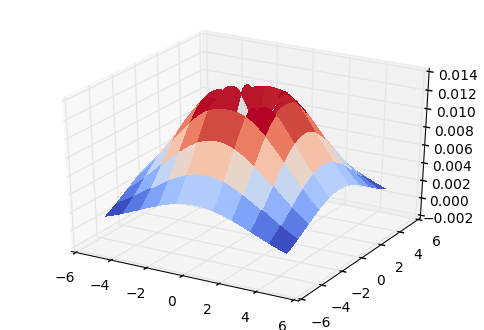

In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

rv = st.multivariate_normal([0, 0], [[10, 0], [0, 10]])
rv2 = st.multivariate_normal([0, 0], [[0.5, 0], [0, 0.5]])

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
Z = rv.pdf(pos) - 0.05 * rv2.pdf(pos)

print(np.min(Z))

# Plot the surface.
surf = ax.plot_surface(x, y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)


In [20]:
np.shape(rv.pdf(pos))

(200, 200)

In [ ]:
class BayesianGame:
    def __init__(self, players, actions, types, prob, util):
        self.players = players
        self.actions = actions
        self.types = types
        self.prob = prob
        self.util = util
        
    def get_waiting_time(current_time):
        return current_time-self.spawn_time
    
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return self.passenger_id == other.passenger_id
        else:
            return False
        

In [7]:
amsterdam_bus_stops_names = ["Amstel", "Amstelveenseweg", "Buikslotermeer","Centraal","Dam",
                                     "Evertsenstraat","Floradorp","Haarlemmermeerstation","Hasseltweg",
                                     "Hendrikkade","Leidseplein","Lelylaan","Muiderpoort","Museumplein",
                                     "RAI","SciencePark","Sloterdijk","Surinameplein","UvA","VU","Waterlooplein",
                                     "Weesperplein","Wibautstraat","Zuid"]

xs = [27, 11, 31, 22, 21, 11, 25, 11, 26, 25, 17, 4, 31, 17, 19, 35, 6, 10, 38, 14, 23, 24, 25, 15]
ys = [7, 4, 30, 21, 18, 18, 30, 9, 24, 18, 14, 12, 13, 11, 3, 10, 26, 13, 11, 1, 16, 13, 11, 4]

connections = [[14, 15, 22], [7, 11, 19, 23], [8], [4, 9, 16, 20], [3, 5, 10], [4, 10, 16, 17], 
                            [8], [1, 13, 17], [2, 6, 9], [3, 8, 20], [4, 5, 13, 17, 21], [1, 16, 17], 
                            [15, 20, 22], [7, 10, 22, 23], [0, 23], [0, 12, 18], [3, 5, 11], [5, 7, 10, 11], 
                            [15], [1, 23], [3, 9, 12, 21], [10, 20, 22], [0, 12, 13, 21], [1, 13, 14, 19]]

In [8]:
def create_estimated_map(self):

    S = len(self.amsterdam_bus_stops_names)
    T = 24
    P = np.zeros((T+1, S, S))
    B = 1000

    for s in range(S):    
        distro = np.zeros(S)
        distro[s] = B
        P[0, :, s] = distro

        for t in range(T):
            aux_distro = np.zeros(S)
            for s_prime in range(S):
                for b in range(int(distro[s_prime])):
                    dest = np.random.choice(self.connections[s_prime])
                    aux_distro[dest] += 1
            distro = aux_distro
            P[t+1, :, s] = distro
    P /= B
    return(P/B)


In [9]:
S = len(amsterdam_bus_stops_names)
T = 10
P = np.zeros((T, S, S))
B = 1000

for s in range(S):    
    distro = np.zeros(S)
    distro[s] = B
    P[0, :, s] = distro

    for t in range(T):
        aux_distro = np.zeros(S)
        for s_prime in range(S):
            for b in range(int(distro[s_prime])):
                dest = np.random.choice(connections[s_prime])
                aux_distro[dest] += 1
        distro = aux_distro
        P[t+1, :, s] = distro
P /= B


In [15]:
print(P[0,:,1])

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]


In [152]:
4**10

1048576

In [ ]:
# Receives a bus B, origin and destination stations O and D, a list of passengers at station O and the current time T
# It is missing to implement attribute capacity for the bus
def pick_up(B,O,D,P,T):
    # Create vector from O to the passenger destiantion weighted by its waiting time
    V = np.array([[ p.get_waiting_time(T) * (p.destination.x - O.x), p.get_waiting_time(T) * (p.destination.y - O.y)] for p in P])
    
    # Create vector from O to D
    w = np.array([ [D.x - O.x] [D.y - O.y]])
    
    # Multiply V with w (equivalent to taking dot product between each v and w)
    x = np.dot(V,w)
    
    # Order the passengers by descending dot product
    ordering = np.argsort(-x)
    
    # Select the best passengers by their dot product score (if they go in the same direction of the bus) until bus capacity
    selected_passengers = []
    for i in range(len(ordering)):
        if x[i] > 0:
            selected_passengers.append(ordering[i])
        # If the bus is full, brake
        if len(selected_passengers) == B.capacity:
            break
    
    return selected_passengers

In [21]:
a = np.array([1, 4, 7, 5])

print(a)
print(np.sort(a))

[1 4 7 5]
[1 4 5 7]


In [30]:

print(ix)

[2 3 1 0]


2
3
1
